In [11]:
from trading_bot.bot.indicator_bot import IndicatorBot
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
bot = IndicatorBot(symbol="ADAUSDT")

data = bot.get_data(
    symbol="ADAUSDT",
    interval="1m",
    target_date=datetime.datetime.strptime("2025-12-13 00:00:00", "%Y-%m-%d %H:%M:%S"),
    limit=1000,
)

Creating UTC logger with level: 20


In [13]:
signal = bot.transform(data)
df = bot.generate_signal(signal)

df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms', utc=True)

# Convert to Bangkok Time (UTC+7)
df['Close Time Bangkok'] = df['Close Time'].dt.tz_convert('Asia/Bangkok')


In [8]:
df

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base,Taker Buy Quote,Ignore,KAMA,signal,Close Time Bangkok
0,1765498800000,0.42530,0.42650,0.42520,0.4265,816082,2025-12-12 00:20:59.999000+00:00,347543.42950,1038,696725,296739.46380,0,NaN,0,2025-12-12 07:20:59.999000+07:00
1,1765498860000,0.42650,0.42690,0.42580,0.4260,560383,2025-12-12 00:21:59.999000+00:00,239001.62240,861,206606,88139.71190,0,NaN,0,2025-12-12 07:21:59.999000+07:00
2,1765498920000,0.42610,0.42630,0.42530,0.4256,492605,2025-12-12 00:22:59.999000+00:00,209731.69490,677,108447,46179.44650,0,NaN,0,2025-12-12 07:22:59.999000+07:00
3,1765498980000,0.42570,0.42600,0.42550,0.4258,326335,2025-12-12 00:23:59.999000+00:00,138956.70880,511,77338,32931.50220,0,NaN,0,2025-12-12 07:23:59.999000+07:00
4,1765499040000,0.42570,0.42610,0.42570,0.4260,156794,2025-12-12 00:24:59.999000+00:00,66780.64160,406,73985,31509.27530,0,NaN,0,2025-12-12 07:24:59.999000+07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1765558500000,0.40450,0.40550,0.40440,0.4048,782406,2025-12-12 16:55:59.999000+00:00,316838.87810,1378,465585,188551.70710,0,0.404757,1,2025-12-12 23:55:59.999000+07:00
996,1765558560000,0.40480,0.40590,0.40430,0.4052,1020744,2025-12-12 16:56:59.999000+00:00,413599.22820,1139,578111,234230.16980,0,0.404821,0,2025-12-12 23:56:59.999000+07:00
997,1765558620000,0.40530,0.40590,0.40490,0.4058,1056267,2025-12-12 16:57:59.999000+00:00,428279.67450,1187,654971,265596.85200,0,0.405014,0,2025-12-12 23:57:59.999000+07:00
998,1765558680000,0.40580,0.40580,0.40420,0.4045,768300,2025-12-12 16:58:59.999000+00:00,311143.33030,1014,364995,147783.17390,0,0.405006,-1,2025-12-12 23:58:59.999000+07:00


In [15]:
! pip install --upgrade ccxt


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [14]:
import ccxt
api_key = os.environ['BINANCE_API_KEY']
api_secret = os.environ['BINANCE_SECRET_KEY']

# 2. INITIALIZE BINANCE FUTURES
# The 'options': {'defaultType': 'future'} is CRITICAL for futures data
exchange = ccxt.binance({
    'apiKey': api_key,
    'secret': api_secret,
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future'  # Switch to Futures market
    }
})

In [15]:
# 3. SETTINGS
symbol = 'ADA/USDT'  # Change to the coin you traded
limit = 1000

In [16]:
exchange.load_markets()
market = exchange.market(symbol)

# 3. FETCH INCOME (Using Implicit Method)
# We must use the raw symbol ID (e.g., "BTCUSDT") not "BTC/USDT"
params = {
    'symbol': market['id'], 
    'incomeType': 'REALIZED_PNL',
    'limit': 500
}

# fapiPrivateGetIncome maps directly to Binance's /fapi/v1/income endpoint
income = exchange.fapiPrivateGetIncome(params)

if not income:
    print(f"No PnL history found for {symbol}.")
else:
    df = pd.DataFrame(income)
    
    # 4. PROCESS DATA
    # Note: Raw API returns 'time' (ms) and 'income' (amount)
    df['timestamp'] = pd.to_datetime(df['time'], unit='ms', utc=True)
    df['Time'] = df['timestamp'].dt.tz_convert('Asia/Bangkok')
    
    # Convert amount to float (raw API returns strings)
    df['income'] = df['income'].astype(float)

    # 5. DISPLAY
    final_df = df[['Time', 'symbol', 'incomeType', 'income']]
    final_df.columns = ['Time', 'Symbol', 'Type', 'PnL']
    
    print(f"--- Realized PnL History for {symbol} ---")
    print(final_df.to_string(index=False))
    print("-" * 30)
    print(f"Total PnL: {final_df['PnL'].sum():.4f} USDT")

--- Realized PnL History for ADA/USDT ---
                     Time  Symbol         Type     PnL
2025-12-09 23:53:20+07:00 ADAUSDT REALIZED_PNL  0.0045
2025-12-09 23:54:15+07:00 ADAUSDT REALIZED_PNL  0.0060
2025-12-09 23:58:37+07:00 ADAUSDT REALIZED_PNL -0.0015
2025-12-10 00:02:54+07:00 ADAUSDT REALIZED_PNL  0.0030
2025-12-10 00:03:06+07:00 ADAUSDT REALIZED_PNL -0.0015
2025-12-10 00:12:50+07:00 ADAUSDT REALIZED_PNL -0.0060
2025-12-10 00:19:39+07:00 ADAUSDT REALIZED_PNL -0.0140
2025-12-10 00:23:41+07:00 ADAUSDT REALIZED_PNL -0.0140
2025-12-10 00:28:35+07:00 ADAUSDT REALIZED_PNL -0.0070
2025-12-10 00:44:05+07:00 ADAUSDT REALIZED_PNL -0.0130
2025-12-10 00:47:02+07:00 ADAUSDT REALIZED_PNL -0.0078
2025-12-10 02:03:08+07:00 ADAUSDT REALIZED_PNL -0.0130
2025-12-10 02:05:29+07:00 ADAUSDT REALIZED_PNL -0.0078
2025-12-10 02:31:52+07:00 ADAUSDT REALIZED_PNL -0.0120
2025-12-10 02:36:58+07:00 ADAUSDT REALIZED_PNL -0.0036
2025-12-10 03:07:08+07:00 ADAUSDT REALIZED_PNL -0.0120
2025-12-10 03:17:31+07:

/var/folders/m8/n99fy2ds2j70c3fm9g4zg65w0000gp/T/ipykernel_1042/2432732421.py:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['time'], unit='ms', utc=True)


In [17]:
# 1. AGGREGATE
# Group by Time, Symbol, and Type, then sum the 'PnL (USDT)' column
combined_df = final_df.groupby(['Time', 'Symbol', 'Type'], as_index=False)['PnL'].sum()

# 2. SORT & DISPLAY
# Sort by time to keep the order correct
combined_df = combined_df.sort_values(by='Time')

In [18]:
combined_df.tail(10)

,Time,Symbol,Type,PnL
144,2025-12-15 23:16:40+07:00,ADAUSDT,REALIZED_PNL,-0.9672
145,2025-12-15 23:24:58+07:00,ADAUSDT,REALIZED_PNL,0.0172
146,2025-12-16 11:36:15+07:00,ADAUSDT,REALIZED_PNL,0.0519
147,2025-12-16 11:49:47+07:00,ADAUSDT,REALIZED_PNL,0.2768
148,2025-12-16 13:06:15+07:00,ADAUSDT,REALIZED_PNL,-0.5775
149,2025-12-16 14:10:11+07:00,ADAUSDT,REALIZED_PNL,0.1837
150,2025-12-16 14:41:03+07:00,ADAUSDT,REALIZED_PNL,-0.6270
151,2025-12-16 17:52:03+07:00,ADAUSDT,REALIZED_PNL,0.1800
152,2025-12-16 20:18:27+07:00,ADAUSDT,REALIZED_PNL,0.1600
153,2025-12-16 20:28:15+07:00,ADAUSDT,REALIZED_PNL,-0.3703


Fetching ADA/USDT market data for comparison...


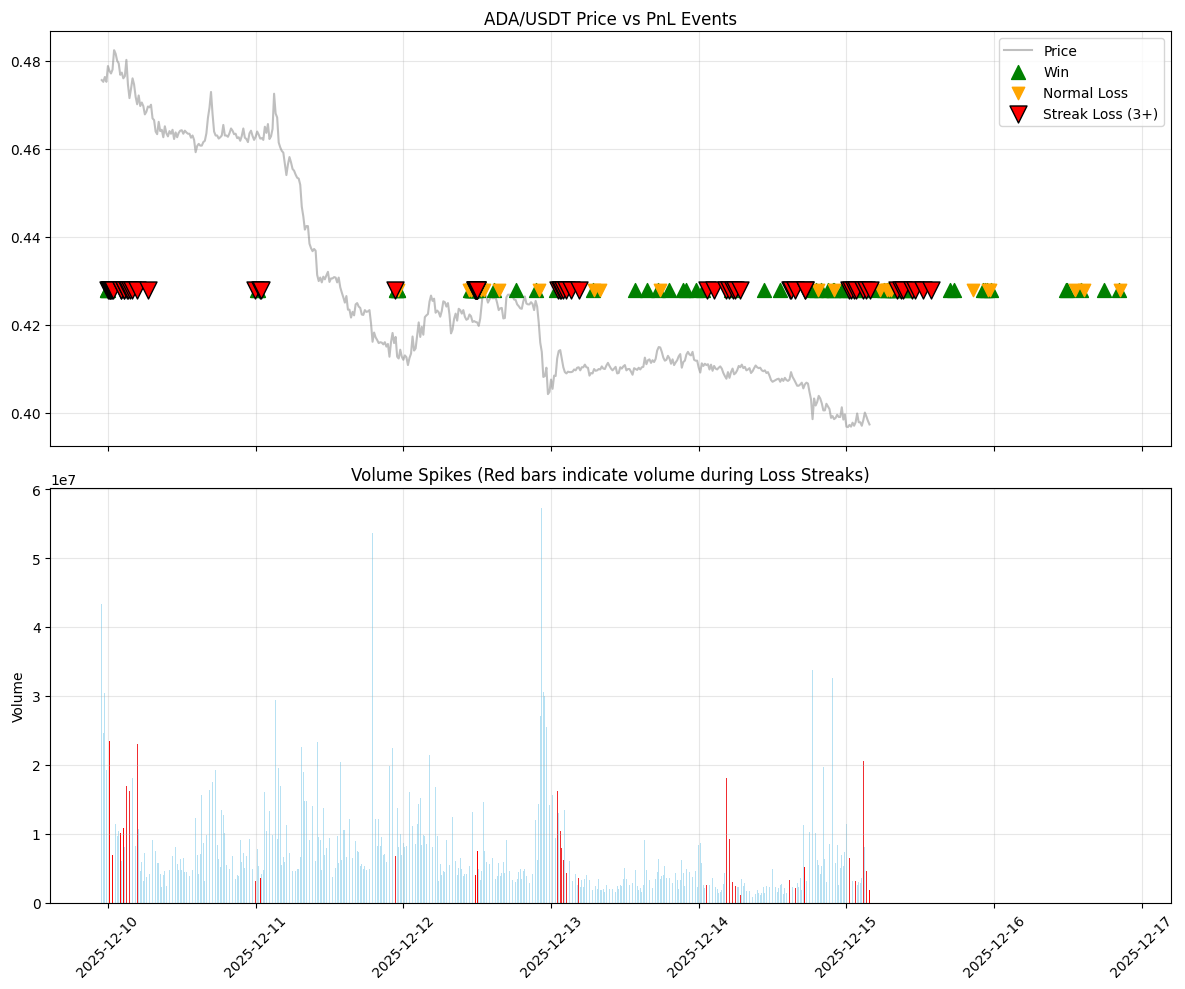

Average Market Volume: 7635051.34

--- Volume Analysis during Loss Streaks ---
Loss at 2025-12-10 00:03:06+07:00: Volume is 2.57x average (SPIKE)
Loss at 2025-12-10 00:12:50+07:00: Volume is 3.07x average (SPIKE)
Loss at 2025-12-10 00:19:39+07:00: Volume is 3.07x average (SPIKE)
Loss at 2025-12-10 00:23:41+07:00: Volume is 1.74x average (SPIKE)
Loss at 2025-12-10 00:28:35+07:00: Volume is 1.74x average (SPIKE)
Loss at 2025-12-10 00:44:05+07:00: Volume is 0.92x average (Normal)
Loss at 2025-12-10 00:47:02+07:00: Volume is 0.92x average (Normal)
Loss at 2025-12-10 02:03:08+07:00: Volume is 1.33x average (Normal)
Loss at 2025-12-10 02:05:29+07:00: Volume is 1.33x average (Normal)
Loss at 2025-12-10 02:31:52+07:00: Volume is 1.42x average (Normal)
Loss at 2025-12-10 02:36:58+07:00: Volume is 1.42x average (Normal)
Loss at 2025-12-10 03:07:08+07:00: Volume is 2.23x average (SPIKE)
Loss at 2025-12-10 03:17:31+07:00: Volume is 2.64x average (SPIKE)
Loss at 2025-12-10 03:32:08+07:00: Volume is

In [19]:
df_pnl = pd.DataFrame(combined_df)
df_pnl['Time'] = pd.to_datetime(df_pnl['Time'])
df_pnl = df_pnl.sort_values('Time')

# 3. IDENTIFY LOSS STREAKS (3 or more losses)
# We create a 'group' ID that changes every time the sign of PnL changes
df_pnl['Win'] = df_pnl['PnL'] > 0
df_pnl['Streak_ID'] = (df_pnl['Win'] != df_pnl['Win'].shift()).cumsum()
# Count size of each streak
df_pnl['Streak_Size'] = df_pnl.groupby('Streak_ID')['Win'].transform('count')
# Mark rows that are part of a loss streak >= 3
df_pnl['Is_Major_Loss_Streak'] = (~df_pnl['Win']) & (df_pnl['Streak_Size'] >= 3)

# 4. FETCH MARKET DATA (Volume)
exchange = ccxt.binance({'enableRateLimit': True, 'options': {'defaultType': 'future'}})
symbol = 'ADA/USDT'
timeframe = '15m' # 15-minute candles to see broad volume trends

# Calculate start/end times (UTC for API)
start_time = int(df_pnl['Time'].min().timestamp() * 1000) - (3600 * 1000) # Buffer 1 hour
end_time = int(df_pnl['Time'].max().timestamp() * 1000) + (3600 * 1000)

print(f"Fetching {symbol} market data for comparison...")
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=start_time, limit=500)
df_mkt = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df_mkt['timestamp'] = pd.to_datetime(df_mkt['timestamp'], unit='ms', utc=True)
df_mkt['timestamp'] = df_mkt['timestamp'].dt.tz_convert('Asia/Bangkok')

# 5. PLOTTING
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# --- Plot 1: Close Price & PnL Markers ---
ax1.plot(df_mkt['timestamp'], df_mkt['close'], color='gray', alpha=0.5, label='Price')

# Plot Wins (Green)
wins = df_pnl[df_pnl['PnL'] > 0]
ax1.scatter(wins['Time'], [df_mkt['close'].mean()] * len(wins), 
            color='green', marker='^', s=100, label='Win', zorder=5)

# Plot Losses (Red) - Normal
losses = df_pnl[(df_pnl['PnL'] <= 0) & (~df_pnl['Is_Major_Loss_Streak'])]
ax1.scatter(losses['Time'], [df_mkt['close'].mean()] * len(losses), 
            color='orange', marker='v', s=80, label='Normal Loss', zorder=5)

# Plot MAJOR Loss Streaks (Dark Red)
streak_losses = df_pnl[df_pnl['Is_Major_Loss_Streak']]
ax1.scatter(streak_losses['Time'], [df_mkt['close'].mean()] * len(streak_losses), 
            color='red', marker='v', s=150, edgecolor='black', label='Streak Loss (3+)', zorder=6)

ax1.set_title(f'{symbol} Price vs PnL Events')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Volume & Loss Correlation ---
# Bar chart for volume
ax2.bar(df_mkt['timestamp'], df_mkt['volume'], width=0.005, color='skyblue', alpha=0.6, label='Volume')

# Highlight Volume bars during loss streaks
# We need to map PnL times to the nearest market candle
for idx, row in streak_losses.iterrows():
    # Find nearest candle
    nearest_idx = df_mkt['timestamp'].sub(row['Time']).abs().idxmin()
    nearest_vol = df_mkt.loc[nearest_idx, 'volume']
    nearest_time = df_mkt.loc[nearest_idx, 'timestamp']
    
    # Draw a red bar on top of the volume to highlight it
    ax2.bar(nearest_time, nearest_vol, width=0.005, color='red', alpha=0.8)

ax2.set_title('Volume Spikes (Red bars indicate volume during Loss Streaks)')
ax2.set_ylabel('Volume')
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. TEXT ANALYSIS
avg_vol = df_mkt['volume'].mean()
print(f"Average Market Volume: {avg_vol:.2f}")

# Check volume during streaks
print("\n--- Volume Analysis during Loss Streaks ---")
for idx, row in streak_losses.iterrows():
    nearest_idx = df_mkt['timestamp'].sub(row['Time']).abs().idxmin()
    vol = df_mkt.loc[nearest_idx, 'volume']
    ratio = vol / avg_vol
    print(f"Loss at {row['Time']}: Volume is {ratio:.2f}x average ({'SPIKE' if ratio > 1.5 else 'Normal'})")

In [20]:
df_pnl.tail(20)

,Time,Symbol,Type,PnL,Win,Streak_ID,Streak_Size,Is_Major_Loss_Streak
134,2025-12-15 11:04:34+07:00,ADAUSDT,REALIZED_PNL,-0.2520,False,54,4,True
135,2025-12-15 12:23:11+07:00,ADAUSDT,REALIZED_PNL,-0.2800,False,54,4,True
136,2025-12-15 13:49:09+07:00,ADAUSDT,REALIZED_PNL,-0.1870,False,54,4,True
137,2025-12-15 16:51:11+07:00,ADAUSDT,REALIZED_PNL,0.2839,True,55,2,False
138,2025-12-15 17:33:02+07:00,ADAUSDT,REALIZED_PNL,0.2004,True,55,2,False
139,2025-12-15 20:29:29+07:00,ADAUSDT,REALIZED_PNL,-0.4706,False,56,1,False
140,2025-12-15 22:08:04+07:00,ADAUSDT,REALIZED_PNL,0.1870,True,57,3,False
141,2025-12-15 22:33:01+07:00,ADAUSDT,REALIZED_PNL,0.2775,True,57,3,False
142,2025-12-15 22:48:04+07:00,ADAUSDT,REALIZED_PNL,0.5400,True,57,3,False
143,2025-12-15 23:01:07+07:00,ADAUSDT,REALIZED_PNL,-0.5211,False,58,2,False


In [41]:
!pip install pandas_ta

  Using cached pandas_ta-0.4.71b0-py3-none-any.whl.metadata (2.3 kB)
  Using cached numba-0.61.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached llvmlite-0.44.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.8 kB)
  Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached pandas_ta-0.4.71b0-py3-none-any.whl (240 kB)
Using cached numba-0.61.2-cp312-cp312-macosx_11_0_arm64.whl (2.8 MB)
Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached llvmlite-0.44.0-cp312-cp312-macosx_11_0_arm64.whl (26.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [21]:
import ccxt
import pandas as pd

# 1. FETCH DATA
exchange = ccxt.binance({'enableRateLimit': True, 'options': {'defaultType': 'future'}})
symbol = 'ADA/USDT'
bars = exchange.fetch_ohlcv(symbol, timeframe='15m', limit=500)
df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Bangkok')

# 2. CALCULATE BOLLINGER BANDS (Manually)
# Middle Band = 20-period Simple Moving Average (SMA)
df['BBM'] = df['close'].rolling(window=20).mean()

# Standard Deviation
df['STD'] = df['close'].rolling(window=20).std()

# Upper and Lower Bands (2 standard deviations)
df['BBU'] = df['BBM'] + (2 * df['STD'])
df['BBL'] = df['BBM'] - (2 * df['STD'])

# 3. CALCULATE BANDWIDTH & FILTER
# Bandwidth: How "fat" are the bands? (Percentage width)
df['bandwidth'] = (df['BBU'] - df['BBL']) / df['BBM']

# Filter: If bandwidth < 1.5% (0.015), it is a SQUEEZE (Choppy/Dangerous)
threshold = 0.015
df['SAFE_TO_TRADE'] = df['bandwidth'] > threshold

# 4. INSPECT
print("--- Bollinger Bandwidth Analysis ---")
print(df[['timestamp', 'close', 'bandwidth', 'SAFE_TO_TRADE']].tail(10))

--- Bollinger Bandwidth Analysis ---
                    timestamp   close  bandwidth  SAFE_TO_TRADE
490 2025-12-16 21:15:00+07:00  0.3839   0.028097           True
491 2025-12-16 21:30:00+07:00  0.3840   0.026691           True
492 2025-12-16 21:45:00+07:00  0.3865   0.024438           True
493 2025-12-16 22:00:00+07:00  0.3865   0.022285           True
494 2025-12-16 22:15:00+07:00  0.3847   0.020183           True
495 2025-12-16 22:30:00+07:00  0.3867   0.019283           True
496 2025-12-16 22:45:00+07:00  0.3899   0.021008           True
497 2025-12-16 23:00:00+07:00  0.3881   0.021534           True
498 2025-12-16 23:15:00+07:00  0.3889   0.022188           True
499 2025-12-16 23:30:00+07:00  0.3878   0.022402           True


In [39]:
import pandas as pd
import ccxt
import numpy as np

# 1. PARSE YOUR PNL DATA

df_trades = df_pnl
threshold = 0.01


# 2. FETCH MARKET DATA (Live from Binance)
exchange = ccxt.binance({'enableRateLimit': True, 'options': {'defaultType': 'future'}})
symbol = 'ADA/USDT'

# Ensure we get enough data covering the trade period
start_ts = int(df_trades['Time'].min().timestamp() * 1000) - (24 * 3600 * 1000)
ohlcv = exchange.fetch_ohlcv(symbol, timeframe='15m', since=start_ts, limit=1000)

df_market = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df_market['timestamp'] = pd.to_datetime(df_market['timestamp'], unit='ms', utc=True)
df_market['timestamp'] = df_market['timestamp'].dt.tz_convert('Asia/Bangkok')

# 3. CALCULATE BOLLINGER BANDWIDTH (Pure Pandas)
df_market['SMA20'] = df_market['close'].rolling(20).mean()
df_market['STD20'] = df_market['close'].rolling(20).std()
df_market['Upper'] = df_market['SMA20'] + (2 * df_market['STD20'])
df_market['Lower'] = df_market['SMA20'] - (2 * df_market['STD20'])

# Bandwidth Formula
df_market['Bandwidth'] = (df_market['Upper'] - df_market['Lower']) / df_market['SMA20']

# 4. MERGE (Backtest)
df_trades = df_trades.sort_values('Time')
df_market = df_market.sort_values('timestamp')

df_merged = pd.merge_asof(
    df_trades, 
    df_market[['timestamp', 'Bandwidth', 'close']], 
    left_on='Time', 
    right_on='timestamp', 
    direction='backward'
)

# 5. FILTER LOGIC
df_merged['Filtered'] = df_merged['Bandwidth'] < threshold

# 6. REPORT
print(f"--- FILTER REPORT (Threshold: {threshold:.3f}) ---")
original_pnl = df_merged['PnL'].sum()
filtered_pnl = df_merged[~df_merged['Filtered']]['PnL'].sum()

print(f"Original PnL: {original_pnl:.4f} USDT")
print(f"Filtered PnL: {filtered_pnl:.4f} USDT")
print(f"Improvement:  {filtered_pnl - original_pnl:.4f} USDT")

print("\n--- Insight: Average Bandwidth ---")
avg_win_bw = df_merged[df_merged['PnL'] > 0]['Bandwidth'].mean()
avg_loss_bw = df_merged[df_merged['PnL'] < 0]['Bandwidth'].mean()
print(f"Avg Bandwidth during WINS:   {avg_win_bw:.4f}")
print(f"Avg Bandwidth during LOSSES: {avg_loss_bw:.4f}")
print("(If Losses have lower Bandwidth than Wins, the filter is scientifically sound.)")

print("\n--- Trades You Would Have Avoided ---")
print(df_merged[(df_merged['Filtered'] == True) & (df_merged['PnL'] < 0)][['Time', 'PnL', 'Bandwidth']])

--- FILTER REPORT (Threshold: 0.010) ---
Original PnL: -3.8511 USDT
Filtered PnL: -1.7384 USDT
Improvement:  2.1127 USDT

--- Insight: Average Bandwidth ---
Avg Bandwidth during WINS:   0.0245
Avg Bandwidth during LOSSES: 0.0327
(If Losses have lower Bandwidth than Wins, the filter is scientifically sound.)

--- Trades You Would Have Avoided ---
                        Time     PnL  Bandwidth
21 2025-12-10 23:57:37+07:00 -0.0042   0.007542
24 2025-12-11 00:39:06+07:00 -0.0100   0.007727
25 2025-12-11 00:52:14+07:00 -0.0095   0.007822
70 2025-12-13 07:02:43+07:00 -0.0816   0.006300
71 2025-12-13 07:57:47+07:00 -0.0500   0.005931
83 2025-12-14 04:24:58+07:00 -0.3792   0.008872
84 2025-12-14 04:54:25+07:00 -0.3276   0.009255
86 2025-12-14 05:34:49+07:00 -0.2530   0.009789
87 2025-12-14 05:54:02+07:00 -0.3390   0.009895
88 2025-12-14 06:44:52+07:00 -0.3315   0.008781
92 2025-12-14 15:03:13+07:00 -0.1736   0.009191
93 2025-12-14 15:42:28+07:00 -0.3408   0.007816
94 2025-12-14 17:13:51+07:00

In [52]:
import pandas as pd
import ccxt
import numpy as np

# 1. PARSE YOUR PNL DATA
data_str = """
176 2025-12-12 12:01:24+07:00 ADAUSDT REALIZED_PNL -0.0091
177 2025-12-12 12:01:51+07:00 ADAUSDT REALIZED_PNL -0.0036
178 2025-12-12 12:07:16+07:00 ADAUSDT REALIZED_PNL 0.0132
179 2025-12-12 12:42:02+07:00 ADAUSDT REALIZED_PNL -0.0072
180 2025-12-12 13:08:45+07:00 ADAUSDT REALIZED_PNL -0.0072
181 2025-12-12 14:41:03+07:00 ADAUSDT REALIZED_PNL 0.0456
182 2025-12-12 15:30:33+07:00 ADAUSDT REALIZED_PNL -0.1938
183 2025-12-12 18:18:33+07:00 ADAUSDT REALIZED_PNL 0.0555
184 2025-12-12 21:38:05+07:00 ADAUSDT REALIZED_PNL 0.1344
185 2025-12-12 22:01:03+07:00 ADAUSDT REALIZED_PNL -0.2034
186 2025-12-13 00:43:50+07:00 ADAUSDT REALIZED_PNL 0.1380
187 2025-12-13 01:03:37+07:00 ADAUSDT REALIZED_PNL -0.1624
188 2025-12-13 01:28:07+07:00 ADAUSDT REALIZED_PNL -0.1680
189 2025-12-13 01:38:49+07:00 ADAUSDT REALIZED_PNL -0.0981
190 2025-12-13 01:53:40+07:00 ADAUSDT REALIZED_PNL -0.1819
191 2025-12-13 02:26:24+07:00 ADAUSDT REALIZED_PNL -0.1484
192 2025-12-13 03:17:36+07:00 ADAUSDT REALIZED_PNL -0.1352
193 2025-12-13 04:30:16+07:00 ADAUSDT REALIZED_PNL -0.0918
194 2025-12-13 06:51:25+07:00 ADAUSDT REALIZED_PNL 0.1300
195 2025-12-13 07:02:43+07:00 ADAUSDT REALIZED_PNL -0.0816
196 2025-12-13 07:57:47+07:00 ADAUSDT REALIZED_PNL -0.0500
197 2025-12-13 13:39:51+07:00 ADAUSDT REALIZED_PNL 0.0693
198 2025-12-13 15:36:01+07:00 ADAUSDT REALIZED_PNL 0.1188
199 2025-12-13 17:21:57+07:00 ADAUSDT REALIZED_PNL 0.1100
200 2025-12-13 17:39:56+07:00 ADAUSDT REALIZED_PNL -0.1616
201 2025-12-13 19:12:03+07:00 ADAUSDT REALIZED_PNL 0.1274
202 2025-12-13 21:30:29+07:00 ADAUSDT REALIZED_PNL 0.1287
203 2025-12-13 21:53:27+07:00 ADAUSDT REALIZED_PNL 0.2868
204 2025-12-13 23:34:37+07:00 ADAUSDT REALIZED_PNL 0.3120
205 2025-12-14 00:41:20+07:00 ADAUSDT REALIZED_PNL 0.2430
206 2025-12-14 01:22:18+07:00 ADAUSDT REALIZED_PNL -0.1960
207 2025-12-14 02:29:11+07:00 ADAUSDT REALIZED_PNL -0.3872
208 2025-12-14 04:24:58+07:00 ADAUSDT REALIZED_PNL -0.3792
209 2025-12-14 04:54:25+07:00 ADAUSDT REALIZED_PNL -0.3276
210 2025-12-14 05:16:15+07:00 ADAUSDT REALIZED_PNL 0.2951
211 2025-12-14 05:34:49+07:00 ADAUSDT REALIZED_PNL -0.2530
212 2025-12-14 05:54:02+07:00 ADAUSDT REALIZED_PNL -0.3390
213 2025-12-14 06:44:52+07:00 ADAUSDT REALIZED_PNL -0.3315
214 2025-12-14 10:33:51+07:00 ADAUSDT REALIZED_PNL 0.2795
215 2025-12-14 13:17:19+07:00 ADAUSDT REALIZED_PNL 0.2834
216 2025-12-14 14:50:01+07:00 ADAUSDT REALIZED_PNL -0.2652
217 2025-12-14 15:03:13+07:00 ADAUSDT REALIZED_PNL -0.1736
218 2025-12-14 15:42:28+07:00 ADAUSDT REALIZED_PNL -0.3408
219 2025-12-14 17:13:51+07:00 ADAUSDT REALIZED_PNL -0.5040
220 2025-12-14 17:14:47+07:00 ADAUSDT REALIZED_PNL -0.2244
221 2025-12-14 18:15:06+07:00 ADAUSDT REALIZED_PNL 0.2600
222 2025-12-14 19:00:39+07:00 ADAUSDT REALIZED_PNL 0.2460
223 2025-12-14 19:19:14+07:00 ADAUSDT REALIZED_PNL -0.2884
224 2025-12-14 19:48:09+07:00 ADAUSDT REALIZED_PNL 0.2412
225 2025-12-14 21:00:07+07:00 ADAUSDT REALIZED_PNL 0.2436
"""

records = []
for line in data_str.strip().split('\n'):
    parts = line.split()
    if len(parts) >= 5:
        ts_str = parts[1] + " " + parts[2]
        pnl = float(parts[-1])
        records.append({'Time': ts_str, 'PnL': pnl})

df_trades = pd.DataFrame(records)

# --- FIX START ---
# Convert to datetime and THEN explicitly convert to 'Asia/Bangkok'
df_trades['Time'] = pd.to_datetime(df_trades['Time']).dt.tz_convert('Asia/Bangkok')
# --- FIX END ---

# 2. FETCH MARKET DATA (Live from Binance)
exchange = ccxt.binance({'enableRateLimit': True, 'options': {'defaultType': 'future'}})
symbol = 'ADA/USDT'

# Ensure we get enough data covering the trade period
start_ts = int(df_trades['Time'].min().timestamp() * 1000) - (24 * 3600 * 1000)
ohlcv = exchange.fetch_ohlcv(symbol, timeframe='15m', since=start_ts, limit=1000)

df_market = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
# Ensure market data is ALSO 'Asia/Bangkok'
df_market['timestamp'] = pd.to_datetime(df_market['timestamp'], unit='ms', utc=True)
df_market['timestamp'] = df_market['timestamp'].dt.tz_convert('Asia/Bangkok')

# 3. CALCULATE BOLLINGER BANDWIDTH (Pure Pandas)
df_market['SMA20'] = df_market['close'].rolling(20).mean()
df_market['STD20'] = df_market['close'].rolling(20).std()
df_market['Upper'] = df_market['SMA20'] + (2 * df_market['STD20'])
df_market['Lower'] = df_market['SMA20'] - (2 * df_market['STD20'])

# Bandwidth Formula
df_market['Bandwidth'] = (df_market['Upper'] - df_market['Lower']) / df_market['SMA20']

# 4. MERGE (Backtest)
df_trades = df_trades.sort_values('Time')
df_market = df_market.sort_values('timestamp')

# Now both are 'Asia/Bangkok', so merge_asof will work
df_merged = pd.merge_asof(
    df_trades, 
    df_market[['timestamp', 'Bandwidth', 'close']], 
    left_on='Time', 
    right_on='timestamp', 
    direction='backward'
)

# 5. FILTER LOGIC
threshold = 0.02  # 1.5% Bandwidth
df_merged['Filtered'] = df_merged['Bandwidth'] < threshold

# 6. REPORT
print(f"--- FILTER REPORT (Threshold: {threshold:.3f}) ---")
original_pnl = df_merged['PnL'].sum()
filtered_pnl = df_merged[~df_merged['Filtered']]['PnL'].sum()

print(f"Original PnL: {original_pnl:.4f} USDT")
print(f"Filtered PnL: {filtered_pnl:.4f} USDT")
print(f"Improvement:  {filtered_pnl - original_pnl:.4f} USDT")

print("\n--- Insight: Average Bandwidth ---")
avg_win_bw = df_merged[df_merged['PnL'] > 0]['Bandwidth'].mean()
avg_loss_bw = df_merged[df_merged['PnL'] < 0]['Bandwidth'].mean()
print(f"Avg Bandwidth during WINS:   {avg_win_bw:.4f}")
print(f"Avg Bandwidth during LOSSES: {avg_loss_bw:.4f}")

print("\n--- Trades You Would Have Avoided ---")
print(df_merged[(df_merged['Filtered'] == True) & (df_merged['PnL'] < 0)][['Time', 'PnL', 'Bandwidth']])

--- FILTER REPORT (Threshold: 0.020) ---
Original PnL: -1.9517 USDT
Filtered PnL: -0.5536 USDT
Improvement:  1.3981 USDT

--- Insight: Average Bandwidth ---
Avg Bandwidth during WINS:   0.0171
Avg Bandwidth during LOSSES: 0.0232

--- Trades You Would Have Avoided ---
                        Time     PnL  Bandwidth
0  2025-12-12 12:01:24+07:00 -0.0091   0.015144
1  2025-12-12 12:01:51+07:00 -0.0036   0.015144
3  2025-12-12 12:42:02+07:00 -0.0072   0.013614
4  2025-12-12 13:08:45+07:00 -0.0072   0.018912
9  2025-12-12 22:01:03+07:00 -0.2034   0.013466
19 2025-12-13 07:02:43+07:00 -0.0816   0.006300
20 2025-12-13 07:57:47+07:00 -0.0500   0.005931
24 2025-12-13 17:39:56+07:00 -0.1616   0.015474
30 2025-12-14 01:22:18+07:00 -0.1960   0.012681
31 2025-12-14 02:29:11+07:00 -0.3872   0.013311
32 2025-12-14 04:24:58+07:00 -0.3792   0.008872
33 2025-12-14 04:54:25+07:00 -0.3276   0.009255
35 2025-12-14 05:34:49+07:00 -0.2530   0.009789
36 2025-12-14 05:54:02+07:00 -0.3390   0.009895
37 2025-12-1